# MNIST e-prop training notebook

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


# from torchvision.datasets import MNIST
# from torchvision import transforms
from torch.utils.data import DataLoader
import torch
import torch.nn as nn

import snntorch as snn 
from snntorch import spikegen
# from snntorch.spikevision import spikedata
import snntorch.spikeplot as splt

import tonic
from tonic import transforms

## Load Datasets and DataLoaders

### Load Neuromorphic-MNIST Datasets

In [2]:
datapath = "../data"
train_dataset = tonic.datasets.NMNIST(datapath, train=True)
test_dataset = tonic.datasets.NMNIST(datapath, train=False)

In [3]:
events, target = train_dataset[60000-1]
events, events.shape, target, train_dataset.__len__()

(array([(18, 30,     55, 1), ( 7, 24,    501, 0), (18,  9,    807, 0), ...,
        ( 8, 20, 302958, 0), (23,  8, 304007, 1), (18, 15, 304231, 1)],
       dtype=[('x', '<i8'), ('y', '<i8'), ('t', '<i8'), ('p', '<i8')]),
 (3551,),
 8,
 60000)

In [6]:
# Convert stream of (x,y,t,p) events into stack of 3 image frames
N_TIME_BINS = 3
FIG_SIZE = (4, 3)
sensor_size = train_dataset.sensor_size
frame_transform = transforms.ToFrame(sensor_size=sensor_size, n_time_bins=N_TIME_BINS)  # 3 saccades

frames = frame_transform(events)
frames.shape

(3, 2, 34, 34)

### Stack events into frames

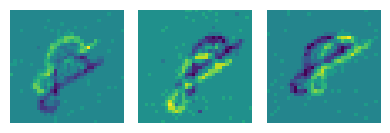

In [8]:
def plot_frames(frames):
    fig, axes = plt.subplots(1, len(frames), figsize=FIG_SIZE)
    for axis, frame in zip(axes, frames):
        axis.imshow(frame[1] - frame[0])
        axis.axis("off")
    plt.tight_layout()


plot_frames(frames)

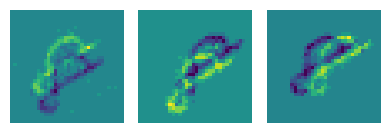

In [9]:
denoise_transform = tonic.transforms.Denoise(filter_time=10000)

events_denoised = denoise_transform(events)
frames_denoised = frame_transform(events_denoised)

plot_frames(frames_denoised)

### Create DataLoaders

We stick with FrameTransform representation for now.

In [10]:
FILTER_TIME = 10000  # Max ms between events otherwise get filtered
N_TIME_BINS = 3  # No. saccades

denoise_transform = transforms.Denoise(filter_time=FILTER_TIME)
frame_transform = transforms.ToFrame(sensor_size=sensor_size, n_time_bins=N_TIME_BINS)
type_transform = transforms.NumpyAsType(dtype = np.float32)  # Events must match weight dtype (torch.float32)

transform = transforms.Compose([denoise_transform, frame_transform, type_transform])

train_dataset = tonic.datasets.NMNIST("../data", train=True, transform=transform)
test_dataset = tonic.datasets.NMNIST("../data", train=False, transform=transform)

In [11]:
# Load Dataloaders
BATCH_SIZE = 1  # Online training

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

torch.Size([1, 3, 2, 34, 34]) 0


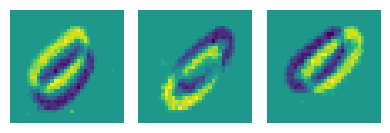

In [12]:
frames, target = next(iter(train_dataloader))
print(frames.shape, target[0].item())
plot_frames(frames[0].squeeze())

## Define Network

For now, feed each frame one by one to network, flattening the polarities (ON and OFF events)

In [14]:
TAU = 5e-3
DT = 1  # ms
BETA = 0.9
THRESHOLD = 1.0
NUM_STEPS = 3  # Number of saccades as earlier

NUM_INPUTS = frames[0,0].flatten().shape[0]  # Take 1 example & 1 time frame, flatten other dims
NUM_HIDDENS = 1000  # Design choice
NUM_OUTPUTS = 10  # Number of output classes
print(f"NUM_INPUTS: {NUM_INPUTS}, NUM_HIDDENS: {NUM_HIDDENS}, NUM_OUTPUTS: {NUM_OUTPUTS}")

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

NUM_INPUTS: 2312, NUM_HIDDENS: 1000, NUM_OUTPUTS: 10


In [16]:
class Net(nn.Module):
    """Simple 3-layer, feed-forward SNN"""

    def __init__(self, num_inputs: int, num_hiddens: int, num_outputs: int, 
                 tau: float, dt, beta: float, threshold: float, num_steps: int):
        """Initialise hyperparameters and architecture"""
        super().__init__()  # Get good stuff from pytorch.nn.Module

        # Hyperparams
        self.tau = tau
        self.dt = dt
        self.beta = beta
        self.threshold = threshold
        self.num_steps = num_steps  # No. simulation steps for 1 example

        # Architecture
        self.fc1 = nn.Linear(in_features=num_inputs, out_features=num_hiddens)
        self.lif1 = snn.Leaky(beta=beta)
        self.fc2 = nn.Linear(in_features=num_hiddens, out_features=num_outputs)
        self.lif2 = snn.Leaky(beta=beta)

    def forward(self, x: torch.Tensor):
        """
        Parameters:
            x: Input tensor (BATCH_SIZE, time_index, polarity, H, W)
        """
        # Put time index first, then flatten -> (time_index, BATCH_SIZE, features_unrolled) 
        x = x.swapaxes(0, 1).flatten(start_dim=2)
        # print(f"x dtype: {x.dtype}, fc1 dtype: {self.fc1.weight.dtype}")
        # print(f"x shape: {x.shape}, fc1 shape: {self.fc1.weight.shape}")

        # Initialise membrane potential tensors
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()

        # Create arrays to store spikes over time
        spk2_rec = []
        mem2_rec = []

        # Iterate over all timesteps for 1 example
        for step in range(self.num_steps):
            cur1 = self.fc1(x[step])  
            spk1, mem1 = self.lif1(cur1, mem1)
            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)

            spk2_rec.append(spk2)  # Store spike outputs & membrane voltage
            mem2_rec.append(mem2)

        return torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec)
    
    def calc_grads(self):
        pass

    def update_params(self):
        pass
    
net = Net(num_inputs=NUM_INPUTS, num_hiddens=NUM_HIDDENS, num_outputs=NUM_OUTPUTS,
          tau=TAU, dt=DT, beta=BETA, threshold=THRESHOLD, num_steps=NUM_STEPS).to(device)
net

Net(
  (fc1): Linear(in_features=2312, out_features=1000, bias=True)
  (lif1): Leaky()
  (fc2): Linear(in_features=1000, out_features=10, bias=True)
  (lif2): Leaky()
)

* `fc1` applies a linear transformation to all input pixels from the MNIST dataset;
* `lif1` integrates the weighted input over time, emitting a spike if the threshold condition is met;
* `fc2` applies a linear transformation to the output spikes of `lif1`;
* `lif2` is another spiking neuron layer, integrating the weighted spikes over time.

## Training

### Define accuracy metric

In [17]:
data, targets = next(iter(train_dataloader))
# data = data.swapaxes(0 ,1)  # time-first, BATCH_SIZE, polarity, H, W
data.shape, targets.shape, data.dtype

(torch.Size([1, 3, 2, 34, 34]), torch.Size([1]), torch.float32)

In [18]:
net(data)[0].shape  # Output shape

torch.Size([3, 1, 10])

In [19]:
def batch_prediction_accuracy(data: torch.Tensor, targets, net: nn.Module, train=False):
    """Classification accuracy
    
    Use rate coding. I.e. take neuron with highest firing rate (spike count) as predicted class.
    Parameters:
        data: batch of data, size (BATCH_SIZE, timesteps, polarity, H, W)
        targets:
        net: network to query
    """
    output_spikes, _ = net(data)
    _, idxs = output_spikes.sum(dim=0).max(1)  # Sum output spikes over time, then find max neuron
    acc = np.mean((targets == idxs).detach().cpu().numpy())

    if train:
        print(f"Train set accuracy for a single minibatch: {acc*100:.2f}%")
    else:
        print(f"Test set accuracy for a single minibatch: {acc*100:.2f}%")

def train_printer(data, targets, net, epoch, counter, iter_counter,
                  loss_hist, test_loss_hist, test_data, test_targets):
    print(f"Epoch {epoch}, Iteration {iter_counter}")
    print(f"Train Set Loss: {loss_hist[counter]:.2f}")
    print(f"Test Set Loss: {test_loss_hist[counter]:.2f}")
    batch_prediction_accuracy(data, targets, net, train=True)
    batch_prediction_accuracy(test_data, test_targets, net, train=False)
    print("\n")

### Define Loss

In [ ]:
torch.Tensor().dot()

In [75]:
def softMax(logits: torch.Tensor):
    """Converts logits to valid probability distribution by applying softmax

    Parameters:
        logits: K-dim Output vector of network (usually total spike counts over time).
    Returns: 
        distribution: K-dim probability vector
    """
    denom = torch.sum(torch.exp(logits), dim=-1)  # Sum over feature dim, avoid batch
    return torch.exp(logits) / denom

def spikeCount(z_out):
    """ Get K-dim spikecount vector
    Parameters:
        z_out: time major output spike tensor, [T=3, BS=1, K=10 output classes]
    Returns:
        K-dim vector of spikecounts for each output class
    """
    return torch.sum(z_out, dim=0).squeeze()  # Sum spikes over time dim (time major)

def computeLoss(z_out: torch.Tensor, target: torch.Tensor):
    """ Compute Cross Entropy loss from output spikes and one-hot targets
    Parameters:
        z_out:
        target:
    """
    spike_counts = spikeCount(z_out)
    predicted_probs = softMax(spike_counts)
    ce_loss = torch.dot(-target, torch.log(predicted_probs)).item()
    
    return ce_loss 


In [76]:
# Test functions

def test_softMax():
    # TODO: Assert same as pytorch softmax fn
    testcase = torch.log(torch.Tensor([1, 2, 3, 4]))
    result = softMax(testcase)
    assert torch.equal(result, torch.Tensor([0.1, 0.2, 0.3, 0.4]))

def test_spikeCount():
    z_out = torch.arange(0, 30).view(size=(3,1,10))
    result = spikeCount(z_out)
    print(result.shape)
    print(result)
    print(z_out)
    assert torch.equal(result, torch.Tensor([30, 33, 36, 39, 42, 45, 48, 51, 54, 57]))

def test_spikeCount_SoftMax():
    # Generate test output w/ 4 output classes, w/ total spike_counts 1,2,3,4
    z_out = torch.ones((3, 1, 4)) / 3
    z_out[:, :, 1] = z_out[:, :, 1] * 2
    z_out[:, :, 2] = z_out[:, :, 2] * 3
    z_out[:, :, 3] = z_out[:, :, 3] * 4
    print(z_out)

    spike_count = spikeCount(z_out)
    print(spike_count)
    spike_count = torch.log(spike_count)
    probs = softMax(spike_count)
    print(probs)

def test_computeLoss():
    z_out = torch.ones((3, 1, 4)) / 3
    z_out[:, :, 1] = z_out[:, :, 1] * 2
    z_out[:, :, 2] = z_out[:, :, 2] * 3
    z_out[:, :, 3] = z_out[:, :, 3] * 4
    print(z_out)

    target = torch.Tensor([0, 0, 0, 1])
    ce_loss = computeLoss(z_out, target)
    

# test_softMax()
# test_spikeCount()
test_computeLoss()

tensor([[[0.3333, 0.6667, 1.0000, 1.3333]],

        [[0.3333, 0.6667, 1.0000, 1.3333]],

        [[0.3333, 0.6667, 1.0000, 1.3333]]])
tensor([1., 2., 3., 4.])
tensor([0.0321, 0.0871, 0.2369, 0.6439])
tensor(0.4402)


### Train and evaluation pipeline for 1 minibatch

In [34]:
data, targets = next(iter(train_dataloader))
data = data.to(device)
targets = targets.to(device)
print(f"databatch size: {data.shape}, targets size: {targets.shape}")

databatch size: torch.Size([128, 3, 2, 34, 34]), targets size: torch.Size([128])


In [35]:
# spk_rec, mem_rec = net(data.view(BATCH_SIZE, -1))
spk_rec, mem_rec = net(data)
print(mem_rec.shape)  # 3 time steps, 128 samples in minibatch, 10 output features/classes

torch.Size([3, 128, 10])


In [36]:
mem_rec[0,0]  # For 1 timestep, for 1 example, 10 output membrane voltages

tensor([-0.2695, -0.1517,  0.1913, -0.0054,  0.0528,  0.2860, -0.2476, -0.0263,
        -0.0785,  0.0076], grad_fn=<SelectBackward0>)

In [37]:
# Initialise loss value
dtype = torch.float
loss_val = torch.zeros((1), dtype=dtype, device=device)

for timestep in range(NUM_STEPS):
    loss_val += loss(mem_rec[timestep], targets)

print(f"Training loss: {loss_val.item():.3f}")

Training loss: 7.042


In [38]:
batch_prediction_accuracy(data, targets, net, train=True)

Train set accuracy for a single minibatch: 8.59%


In [39]:
# Single weight update iteration
optimizer.zero_grad()  # Clear previous gradients
loss_val.backward()
optimizer.step()

In [40]:
# Re print accuracy after training
spk_rec, mem_rec = net(data)
loss_val = torch.zeros((1), dtype=dtype, device=device)

for timestep in range(NUM_STEPS):
    loss_val += loss(mem_rec[timestep], targets)

print(f"Training loss: {loss_val.item():.3f}")
batch_prediction_accuracy(data, targets, net, train=True)

Training loss: 5.554
Train set accuracy for a single minibatch: 25.00%


- Note loss has decreased after iteration

### Training loop

In [41]:
NUM_EPOCHS = 1

# Initialise tracking variables
counter = 0  # total iteration counter
train_loss_hist = []
test_loss_hist = []

# Outer Training loop
for epoch in range(NUM_EPOCHS):
    iter_counter = 0  # keep track of iterations within an epoch

    # Loop over each minibatch
    for data, targets in iter(train_dataloader):

        data = data.to(device)
        targets = targets.to(device)
        net.train()  # Set module to training mode

        # Forward pass
        spk_rec, mem_rec = net(data)

        # Initialise loss and sum over time
        loss_val = torch.zeros((1), dtype=dtype, device=device)
        for timestep in range(NUM_STEPS):
            loss_val += loss(mem_rec[timestep], targets)
        
        # Backward pass
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        # Store loss
        train_loss_hist.append(loss_val.item())

        # Test set
        with torch.no_grad():  # Disable gradient tracking when evaluating
            net.eval()  # Set net to eval mode
            test_data, test_targets = next(iter(test_dataloader))
            output_spikes, output_memb_pots = net(test_data)

            test_loss = torch.zeros((1), dtype=dtype, device=device)

            for timestep in range(NUM_STEPS):
                test_loss += loss(output_memb_pots[timestep], test_targets)  # Note that loss values are summed/averaged over minibatch
            test_loss_hist.append(test_loss.item())

            # Print train/test loss and accuracy
            if counter % 50 == 0:
                train_printer(data, targets, net, epoch, counter,
                              iter_counter, train_loss_hist, test_loss_hist,
                              test_data, test_targets)
            counter += 1
            iter_counter += 1



Epoch 0, Iteration 0
Train Set Loss: 6.15
Test Set Loss: 5.48
Train set accuracy for a single minibatch: 40.62%
Test set accuracy for a single minibatch: 33.59%


Epoch 0, Iteration 50
Train Set Loss: 1.18
Test Set Loss: 0.95
Train set accuracy for a single minibatch: 78.91%
Test set accuracy for a single minibatch: 71.88%


Epoch 0, Iteration 100
Train Set Loss: 1.05
Test Set Loss: 1.08
Train set accuracy for a single minibatch: 80.47%
Test set accuracy for a single minibatch: 81.25%


Epoch 0, Iteration 150
Train Set Loss: 0.63
Test Set Loss: 0.88
Train set accuracy for a single minibatch: 78.91%
Test set accuracy for a single minibatch: 82.81%


Epoch 0, Iteration 200
Train Set Loss: 0.50
Test Set Loss: 0.63
Train set accuracy for a single minibatch: 86.72%
Test set accuracy for a single minibatch: 82.81%


Epoch 0, Iteration 250
Train Set Loss: 0.63
Test Set Loss: 0.48
Train set accuracy for a single minibatch: 88.28%
Test set accuracy for a single minibatch: 89.84%


Epoch 0, Iter

## Plot Learning Curves

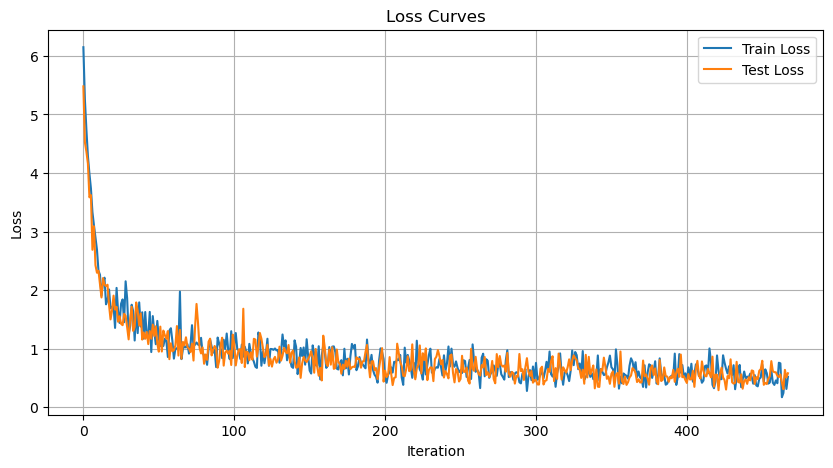

In [43]:
# Plot Loss
fig = plt.figure(facecolor="w", figsize=(10, 5))
plt.plot(train_loss_hist)
plt.plot(test_loss_hist)
plt.title("Loss Curves")
plt.legend(["Train Loss", "Test Loss"])
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.grid()
plt.show()

### Test set accuracy

Instead of computing loss, with is calculated based on membrane potential, use max firing rate to classify:

In [45]:
total = 0
correct = 0

# drop_last switched to False to keep all samples
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=False)

with torch.no_grad():
  net.eval()
  for data, targets in test_loader:
    data = data.to(device)
    targets = targets.to(device)

    # forward pass
    test_spk, _ = net(data)

    # calculate total accuracy
    _, predicted = test_spk.sum(dim=0).max(1)
    total += targets.size(0)
    correct += (predicted == targets).sum().item()

print(f"Total correctly classified test set images: {correct}/{total}")
print(f"Test Set Accuracy: {100 * correct / total:.2f}%")

Total correctly classified test set images: 8922/10000
Test Set Accuracy: 89.22%
